# Model Evaluation

Load trained model and evaluate on test set.

## 1. Setup

In [13]:
import sys
sys.path.insert(0, '..')

import warnings
warnings.filterwarnings('ignore')

import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mlflow
from pathlib import Path

from src.data import DataLoader
from src.evaluate import Evaluator

PROCESSED_DIR = Path('../data/processed')
MODELS_DIR = Path('../models')

plt.style.use('seaborn-v0_8-whitegrid')

# Setup MLflow
mlflow.set_experiment("fraud-detection-evaluation")
print("MLflow tracking enabled")

MLflow tracking enabled


## 2. Load Model and Data

In [14]:
# Load trained model
model_path = MODELS_DIR / 'fraud_detector.joblib'
model = joblib.load(model_path)
print(f"Loaded model from {model_path}")
print(f"Model type: {type(model).__name__}")

Loaded model from ../models/fraud_detector.joblib
Model type: XGBClassifier


In [15]:
# Load test data
loader = DataLoader()
df = loader.load_parquet(PROCESSED_DIR / 'features.parquet')
X_train, X_test, y_train, y_test = loader.split(df)

print(f"Test set: {len(X_test):,} rows")
print(f"Test fraud rate: {y_test.mean()*100:.2f}%")

Test set: 370,479 rows
Test fraud rate: 0.52%


## 3. Threshold Optimization

In [16]:
from sklearn.metrics import precision_recall_curve

# Get predictions
y_proba = model.predict_proba(X_test)[:, 1]

# Find best threshold for recall (prioritize catching fraud)
evaluator = Evaluator(model)
best_threshold = evaluator.find_best_threshold(X_test, y_test, optimize_for='recall')
print(f"Best threshold for recall: {best_threshold:.3f}")

# Also show F1 threshold for comparison
threshold_f1 = evaluator.find_best_threshold(X_test, y_test, optimize_for='f1')
print(f"Threshold for best F1: {threshold_f1:.3f}")

Best threshold for recall: 0.500
Threshold for best F1: 0.771


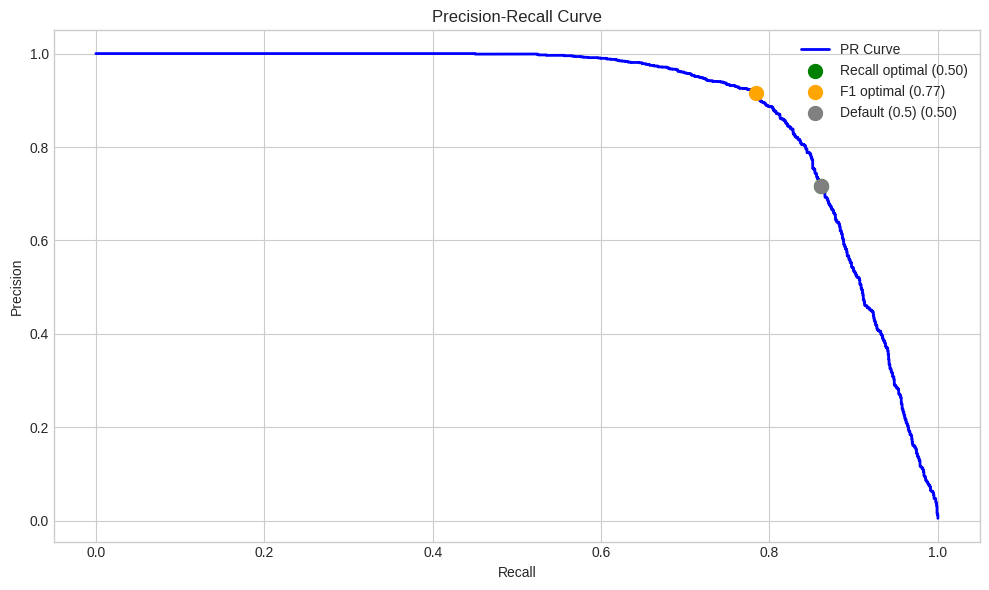

In [17]:
# Plot PR curve with threshold options
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, 'b-', linewidth=2, label='PR Curve')

# Mark different threshold options
for thresh, name, color in [
    (best_threshold, 'Recall optimal', 'green'),
    (threshold_f1, 'F1 optimal', 'orange'),
    (0.5, 'Default (0.5)', 'gray'),
]:
    idx = np.argmin(np.abs(thresholds - thresh))
    plt.scatter(recall[idx], precision[idx], s=100, c=color, zorder=5, label=f'{name} ({thresh:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 4. Final Metrics

In [18]:
# Evaluate with optimized threshold
with mlflow.start_run(run_name="final_evaluation"):
    metrics = evaluator.evaluate(X_test, y_test, threshold=best_threshold, log_to_mlflow=False)
    
    # Log to MLflow
    mlflow.log_metrics({
        "pr_auc": metrics.pr_auc,
        "roc_auc": metrics.roc_auc,
        "f1": metrics.f1,
        "precision": metrics.precision,
        "recall": metrics.recall,
    })
    mlflow.log_param("threshold", best_threshold)

    print("Final Metrics:")
    print(f"  PR-AUC: {metrics.pr_auc:.4f}")
    print(f"  ROC-AUC: {metrics.roc_auc:.4f}")
    print(f"  F1: {metrics.f1:.4f}")
    print(f"  Precision: {metrics.precision:.4f}")
    print(f"  Recall: {metrics.recall:.4f}")
    print(f"  Threshold: {metrics.threshold:.3f}")
    
    # Dynamic finding
    print(f"\n--- Finding ---")
    if metrics.recall > 0.8 and metrics.precision > 0.5:
        print("Excellent balance: catching most fraud with reasonable precision.")
    elif metrics.recall > 0.7:
        print(f"Good recall ({metrics.recall:.1%}), but precision could improve.")
    else:
        print(f"Recall is {metrics.recall:.1%}. Consider lowering threshold to catch more fraud.")

Final Metrics:
  PR-AUC: 0.8939
  ROC-AUC: 0.9971
  F1: 0.7830
  Precision: 0.7174
  Recall: 0.8617
  Threshold: 0.500

--- Finding ---
Excellent balance: catching most fraud with reasonable precision.


## 5. Classification Report

In [19]:
# Full classification report
evaluator.print_report(X_test, y_test, threshold=best_threshold)

Threshold: 0.500

Classification Report:
              precision    recall  f1-score   support

       Legit       1.00      1.00      1.00    368549
       Fraud       0.72      0.86      0.78      1930

    accuracy                           1.00    370479
   macro avg       0.86      0.93      0.89    370479
weighted avg       1.00      1.00      1.00    370479

Confusion Matrix:
  TN: 367,894  FP: 655
  FN: 267  TP: 1,663


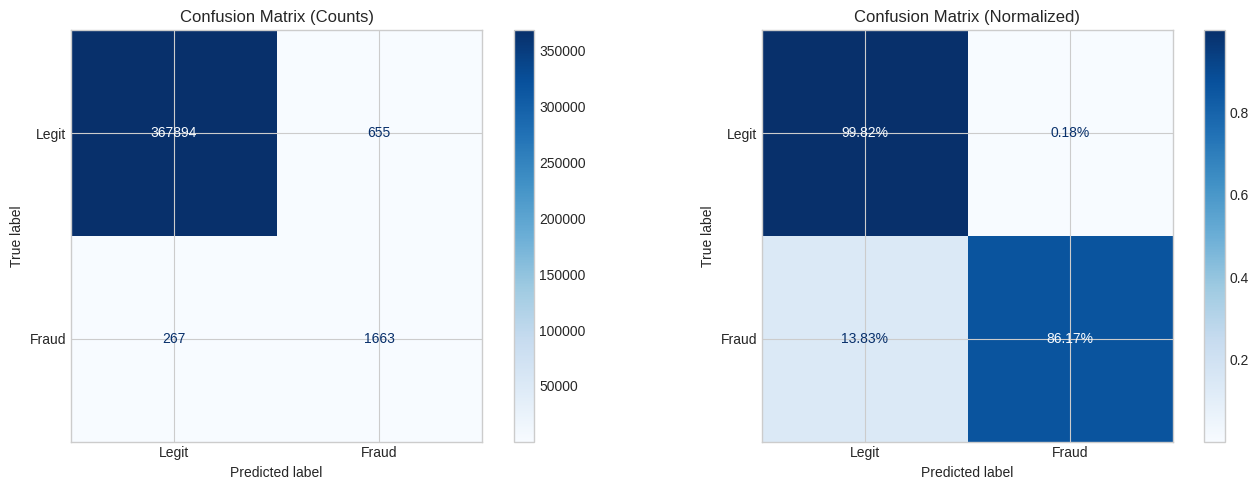


Detailed breakdown:
  True Negatives (legit correctly identified): 367,894
  False Positives (legit flagged as fraud): 655
  False Negatives (fraud missed): 267
  True Positives (fraud caught): 1,663


In [20]:
# Confusion matrix visualization
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = (y_proba >= best_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw counts
ConfusionMatrixDisplay(cm, display_labels=['Legit', 'Fraud']).plot(ax=axes[0], cmap='Blues')
axes[0].set_title('Confusion Matrix (Counts)')

# Normalized
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
ConfusionMatrixDisplay(cm_norm, display_labels=['Legit', 'Fraud']).plot(ax=axes[1], cmap='Blues', values_format='.2%')
axes[1].set_title('Confusion Matrix (Normalized)')

plt.tight_layout()
plt.show()

print(f"\nDetailed breakdown:")
print(f"  True Negatives (legit correctly identified): {cm[0,0]:,}")
print(f"  False Positives (legit flagged as fraud): {cm[0,1]:,}")
print(f"  False Negatives (fraud missed): {cm[1,0]:,}")
print(f"  True Positives (fraud caught): {cm[1,1]:,}")

## 6. Feature Importance

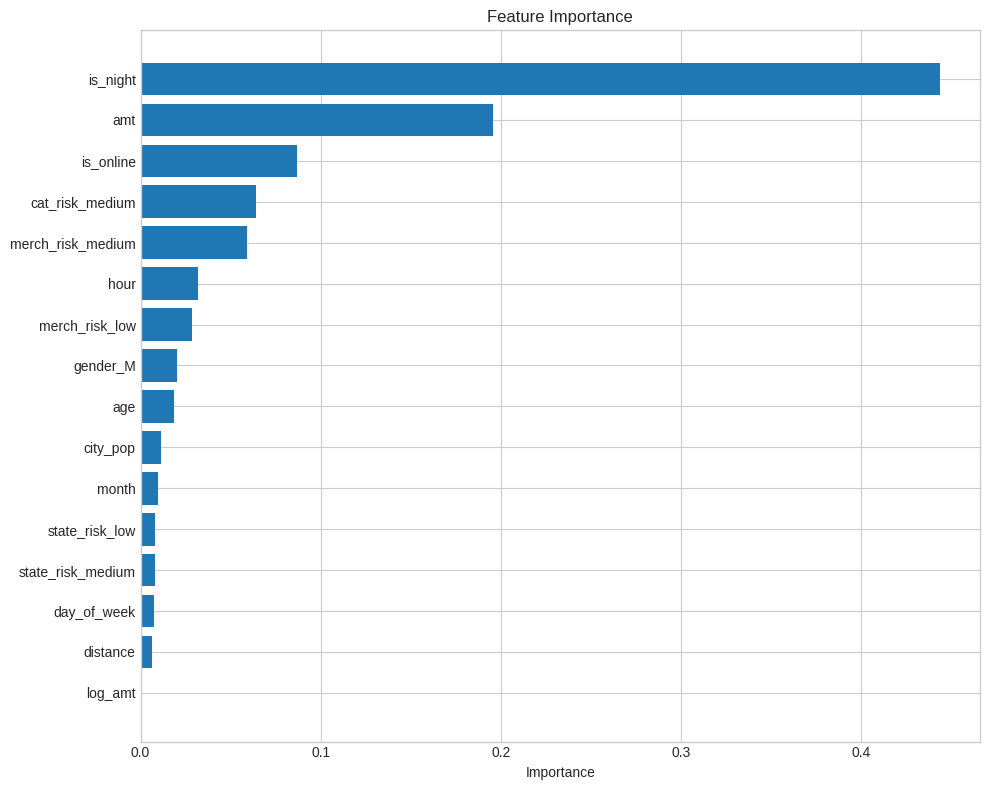


--- Finding: Top 5 Features ---
  is_night: 0.4438
  amt: 0.1955
  is_online: 0.0871
  cat_risk_medium: 0.0643
  merch_risk_medium: 0.0588


In [21]:
# Feature importance
if hasattr(model, 'feature_importances_'):
    importances = pd.DataFrame({
        'feature': X_test.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=True)
    
    plt.figure(figsize=(10, 8))
    plt.barh(importances['feature'], importances['importance'])
    plt.xlabel('Importance')
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()
    
    # Dynamic finding
    print("\n--- Finding: Top 5 Features ---")
    top5 = importances.tail(5).iloc[::-1]
    for _, row in top5.iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")
else:
    print("Model doesn't have feature_importances_ attribute")

## 7. Error Analysis

In [22]:
# Analyze false negatives (missed fraud)
y_pred = (y_proba >= best_threshold).astype(int)

false_negatives = X_test[(y_test == 1) & (y_pred == 0)].copy()
false_negatives['proba'] = y_proba[(y_test == 1) & (y_pred == 0)]

print(f"False Negatives (missed fraud): {len(false_negatives):,}")
print(f"\nProbability distribution of missed fraud:")
print(false_negatives['proba'].describe())

# How many were close to threshold?
close_misses = (false_negatives['proba'] > best_threshold - 0.1).sum()
print(f"\nClose misses (proba > {best_threshold-0.1:.2f}): {close_misses} ({close_misses/len(false_negatives)*100:.1f}%)")

False Negatives (missed fraud): 267

Probability distribution of missed fraud:
count    267.000000
mean       0.202023
std        0.152834
min        0.000236
25%        0.052924
50%        0.190028
75%        0.322276
max        0.499175
Name: proba, dtype: float64

Close misses (proba > 0.40): 41 (15.4%)


In [23]:
# Analyze false positives (false alarms)
false_positives = X_test[(y_test == 0) & (y_pred == 1)].copy()
false_positives['proba'] = y_proba[(y_test == 0) & (y_pred == 1)]

print(f"False Positives (false alarms): {len(false_positives):,}")
print(f"\nProbability distribution of false alarms:")
print(false_positives['proba'].describe())

False Positives (false alarms): 655

Probability distribution of false alarms:
count    655.000000
mean       0.670622
std        0.134358
min        0.500158
25%        0.558945
50%        0.640219
75%        0.751626
max        0.988825
Name: proba, dtype: float64


## 8. Summary

In [24]:
# Dynamic summary
print("=" * 50)
print("EVALUATION SUMMARY")
print("=" * 50)

print(f"\nModel: {type(model).__name__}")
print(f"Threshold: {best_threshold:.3f}")

print(f"\nPerformance:")
print(f"  F1 Score: {metrics.f1:.4f}")
print(f"  Precision: {metrics.precision:.4f}")
print(f"  Recall: {metrics.recall:.4f}")
print(f"  PR-AUC: {metrics.pr_auc:.4f}")

print(f"\nConfusion Matrix Summary:")
print(f"  Fraud caught: {cm[1,1]:,} / {cm[1,0]+cm[1,1]:,} ({cm[1,1]/(cm[1,0]+cm[1,1])*100:.1f}%)")
print(f"  False alarms: {cm[0,1]:,} / {cm[0,0]+cm[0,1]:,} ({cm[0,1]/(cm[0,0]+cm[0,1])*100:.2f}%)")


EVALUATION SUMMARY

Model: XGBClassifier
Threshold: 0.500

Performance:
  F1 Score: 0.7830
  Precision: 0.7174
  Recall: 0.8617
  PR-AUC: 0.8939

Confusion Matrix Summary:
  Fraud caught: 1,663 / 1,930 (86.2%)
  False alarms: 655 / 368,549 (0.18%)
